# Big Data Platform
## Assignment 3: ServerLess

**By:**  

Or Livne, 300123123  
Roy Rubin, 201312907

<br><br>

**The goal of this assignment is to:**
- Understand and practice the details of Serverless

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of your team.
- Your solution is in the form of a Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- You are expected to submit a clear and pythonic code.
- You can change functions signatures/definitions.

**Submission:**
- Submission of the homework will be done via Moodle by uploading (not Zip):
    - Jupyter Notebook
    - 2 Log files
    - Additional local scripts
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.
- Late submission won't be allowed.

  
- In case of identical code submissions - both groups will get a Zero. 
- Some groups might be selected randomly to present their code.

**Requirements:**  
- Python 3.6 should be used.  
- You should implement the algorithms by yourself using only basic Python libraries (such as numpy,pandas,etc.)

<br><br><br><br>

**Grading:**
- Q0 - 10 points - Setup
- Q1 - 40 points - Serverless MapReduceEngine
- Q2 - 20 points - MapReduce job to calculate inverted index
- Q3 - 30 points - Shuffle

`Total: 100`

<br><br>

# Question 0
## Setup

1. Navigate to IBM Cloud and open a trial account. No need to provide a credit card
2. Choose IBM Cloud Object Storage service from the catalog
3. Create a new bucket in IBM Cloud Object Storage
4. Create credentials for the bucket with HMAC (access key and secret key)
5. Choose IBM Cloud Functions service from the catalog and create a service


#### Lithops setup
1. By using “git” tool, install master branch of the Lithops project from
https://github.com/lithops-cloud/lithops
2. Follow Lithops documentation and configure Lithops against IBM Cloud Functions and IBM Cloud Object Storage
3. Configure Lithops log level to be in DEBUG mode
4. Run Hello World example by using Futures API and verify all is working properly.


#### IBM Cloud Object Storage setup
1. Upload all the input CSV files that you used in homework 2 into the bucket you created in IBM Cloud Object Storage


<br><br><br>

# Question 1
## Serverless MapReduceEngine

Modify MapReduceEngine from homework 2 into the MapReduceServerlessEngine where map and reduce tasks executed as a serverless actions, instead of local threads. In particular:
1. Deploy all map tasks as a serverless actions by using Lithops against IBM Cloud Functions.
2. Collect results from all map tasks and store them in the same SQLite as you used in MapReduceEngine and use the same code for the sort and shuffle phase.
3. Deploy reduce tasks by using Lithops against IBM Cloud Functions. Instead of persisting results from reduce tasks, return results back to the MapReduceServerlessEngine and proceed with the same workflow as in MapReduceEngine
4. Return results of reduce tasks to the user

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [1]:
!python --version

Python 3.8.5


#### Imports

In [2]:
import glob
import os
from io import StringIO, BytesIO

import numpy as np
import pandas as pd
import sqlite3

import lithops
from lithops import Storage

#### Set our IBM configurations

<div class="alert alert-block alert-info">
for HW checker - if you wish to use your own connector, please change config accordingly

In [3]:
global_config = {
    'lithops': 
        {
        'backend': 'ibm_cf',
        'storage': 'ibm_cos',
        # 'log_level': 'DEBUG'  # Log files included seperatly. uncomment if needed.
        },
    'ibm_cf': 
        {
        'endpoint': 'https://us-south.functions.cloud.ibm.com',
        'namespace': 'roy.rubin@post.idc.ac.il_dev',
        'api_key': '1defbac0-eea1-4bb8-b5d4-cee7e63b3bb4:63a0ls32DAGjVe0TkdUcBqcOL7lOtR7bLsQYf98WGgW2xpp9Bpd0BUSubnlsfNQM',
        },
    'ibm_cos': 
        {
        'storage_bucket': 'cloud-object-storage-mq-cos-standard-8s4',
        'region': 'eu-de',
        "access_key": "bb21b4d35ef046d19b4f6fd93f39a3a5",
        "secret_key": "d9db9b67564ec2fc5467820ef8719533cdc2e64a5ce33695",
        }
}

#### Additional Configurations

In [4]:
def init_configurations():
    # Set the value options
    global max_rows, csv_columns, db_file_name, csv_file_name, columns_type
    global csv_index, csv_ending, amount_of_files
    global map_reduce_folder_names, amount_of_process, map_regex, db_columns
    global db_columns_type, db_table_name, reduce_regex_init, reduce_regex_final

    Current_python_file_path = os.getcwd()
    max_rows = 10
    amount_of_files = 20
    csv_columns = ['firstname', 'secondname', 'city']
    csv_file_name = 'myCSV'
    csv_ending = '.csv'
    
    # db_definitions
    db_columns = ['key', 'value']
    db_columns_type = ['text', 'text']
    db_file_name = 'mydata.db'
    db_table_name = 'temp_results'

    return

#### Our map and reduce functions

In [5]:
def inverted_map(document_name: str):
    try:
        # Preparations
        storage = Storage(config=global_config)
        data = storage.get_object(global_config['ibm_cos']['storage_bucket'], document_name)

        # Begin
        csv_df = pd.read_csv(BytesIO(data), encoding='utf8', sep=",", index_col=0)
        csv_size = csv_df.shape[0]
        csv_columns = csv_df.columns.to_list()
        output_list = []
        for i_col in csv_columns:
            col_vals = csv_df[i_col].to_list()
            curr_ouput = list(map(lambda x, y, z: (x + '_' + y, z), csv_size * [i_col], col_vals, csv_size * [document_name]))
            output_list += curr_ouput

    except Exception as exception:
        return [], False

    return output_list, True


def inverted_reduce(data):
    try:
        value, documents = data
        ducument_name_list = documents.split(',')
        ducument_name_list_no_duplicates = list(set(ducument_name_list))
        string_ducument_name_list_no_duplicates = (', ').join(ducument_name_list_no_duplicates)
        return_list = [value, string_ducument_name_list_no_duplicates]

    except Exception as exception:
        return [], False

    return return_list, True


#### Serverless Map Reduce Engine !

In [6]:
class MapReduceServerlessEngine(object):
    def __init__(self):
        # create a function executor
        self._fexec = lithops.FunctionExecutor(config=global_config)
        self._bucket_name = global_config['ibm_cos']['storage_bucket']
        self._region_name = global_config['ibm_cos']['region']
        self._create_database()

    def execute(self, input_data, map_function, reduce_function):
        """
        execute map and reduce

        :param input_data: assumption: given as:     input_data = 'cos://bucket/<path to CSV data>'
        :param map_function:
        :param reduce_function:
        :return:
        """
        #  1) For each key  from the  input_data, start a new Python thread that executes
        #     map_function(key)
        #  2) Each serverless action will store results of the map_function into
        #     mapreducetemp/part-tmp-X.csv where X
        #     is a unique number per each thread.
        #  3) Keep the list of all threads and check whether they are completed

        # Create cloud storage object
        self._storage = Storage(config=global_config)
        _, _, path_to_csv = self._parse_input_data(input_data)

        list_of_objects = self._storage.list_objects(bucket=self._bucket_name, prefix=path_to_csv)
        list_of_csv_objects = [item for item in list_of_objects if '.csv' in item['Key']]
        list_of_csv_names = [item['Key'] for item in list_of_csv_objects if '.csv' in item['Key']]

        # call function async-ly
        response_list = []
        for csv_name in list_of_csv_names:
            response = self._fexec.call_async(func=map_function, data={'document_name': csv_name})
            response_list.append(response)

        try:
            results = self._fexec.get_result(fs=response_list)  # internally calls wait. note: if one fails, all fails !
            self._fexec.clean()
        except Exception as exception:
            status = 'Map Reduce Failed'
            return status

        # get all map logs
        map_loglist = list(map(lambda x: x.logs, response_list))
        
        # get list of succeed or failed of threads
        boolean_results = [boolean for output, boolean in results]

        # validate that all threads are completed succesfully
        if False in boolean_results:
            status = 'Map Reduce Failed'
            return status

        # 4) Once all threads completed, load content of all CSV files into the temp_results
        #    table in SQLite

        # get new files names
        outputs = [output for output, boolean in results]

        # write generated csv files to sql data base
        sql_conn = sqlite3.connect(db_file_name)
        for output in outputs:
            result_df = pd.DataFrame(data=output, columns=['key', 'value'])
            result_df.to_sql('temp_results', sql_conn, if_exists='append', index=False)

        # dont forget to close connection after finishing
        sql_conn.close()

        # 5) **Write SQL statement** that generates a sorted list by key of the form
        #    `(key, value)` where value is concatenation of ALL values in the value column
        #     that match specific key. For example, if table has records

        # query data base using GROUP_CONCAT and GROUP BY  and ORDER BY
        generated_list = self._get_grouped_info_from_db_by_key(key='key')

        # 6) **Start a new serverless execution** for each value from
        #    the generated list in the previous step, to execute `reduce_function(key,value)
        #    Begin by Performing REDUCE actions
        #    we will open a thread for each REDUCE
        # 7) Each thread will store results of reduce_function into
        #   `mapreducefinal/part-X-final.csv` file

        # 8) Keep list of all threads and check whether they are completed

        # call function async-ly
        response_list = []
        for item in generated_list:
            response = self._fexec.call_async(func=reduce_function, data={'data': item})
            response_list.append(response)

        try:
            results = self._fexec.get_result(fs=response_list)  # internally calls wait. note: if one fails, all fails !
            self._fexec.clean()
        except Exception as exception:
            status = 'Map Reduce Failed'
            return status

        # 9) Once all threads completed, print on the screen
        #   `MapReduce Completed` otherwise print `MapReduce Failed`
        
        # get all reduce logs
        reduce_loglist = list(map(lambda x: x.logs, response_list))

        # get list of succeed or failed of threads
        boolean_results = [boolean for output, boolean in results]

        # validate that all threads are completed succesfully
        if False in boolean_results:
            status = 'Map Reduce Failed'
            return status

        # write all serverless execution logs (for each "response" object) to file
        log_seprator = '----------------------------------'
        map_and_reduce_logs = [log_seprator+ 'Map log' + log_seprator] + map_loglist + reduce_loglist + [log_seprator+'Reduce log' +log_seprator]
        write_list_to_txt_file('future_responses_logs_file.txt', map_and_reduce_logs)

        # return map+reduce output as pandas dataframe for user
        outputs = [output for output, boolean in results]
        reduce_df = pd.DataFrame(data=outputs)
        return reduce_df


    def _get_grouped_info_from_db_by_key(self, key):
        con = sqlite3.connect(db_file_name)
        cur = con.cursor()
        return_list = []
        for row in cur.execute(
                'SELECT key, GROUP_CONCAT(value) FROM ' + db_table_name + ' GROUP BY ' + key + ' ORDER BY ' + key):
            # print(row)
            return_list.append(row)
        con.close()
        return return_list

    def _parse_input_data(self, input_data: str):
        """

        :param input_data: assumption: format is something like :  input_data = 'cos://eu-de/cloud-object-storage-mq-cos-standard-8s4/myCSV0.csv'
        :return:
        """

        if input_data is None or input_data == '':
            raise AssertionError(f'Bad arguments passed: input_data is None or input_data == ''')

        sep = '/'
        parts = input_data.split(sep='cos://')[1].split(sep=sep)

        region = parts[0]
        bucket = parts[1]
        path_to_csv = sep + sep.join(parts[2:])

        if self._bucket_name != bucket:
            raise AssertionError(f'bucket name in input data does not match the one given in global config')
        if self._region_name != region:
            raise AssertionError(f'region name in input data does not match the one given in global config')

        return region, bucket, path_to_csv

    def _create_database(self):
        is_exist = os.path.exists(db_file_name)
        if is_exist:
            os.remove(db_file_name)
        con = sqlite3.connect(db_file_name)

        cur = con.cursor()

        # Create table
        columns_type_list = list(map(lambda x, y: x + ' ' + y, db_columns, db_columns_type))
        columns_type_list_string = "(" + ", ".join(map(str, columns_type_list)) + ")"

        cur.execute(''' 
                    CREATE TABLE temp_results
                    ''' + columns_type_list_string + \
                    '''''')

        con.commit()
        con.close()
        return


#### Assisting functions

In [7]:
def write_list_to_txt_file(path, List):
    with open(path, 'w') as f:
        for item in List:
            f.write("%s\n" % item)
    f.close()
    return

# Task 2
## Submit MapReduce job to calculate inverted index
1. Use input_data: `cos://bucket/<path to CSV data>`
2. Submit MapReduce job with reduce and map functions as you used in homework 2, as follows

    `mapreduce = MapReduceServerlessEngine()`  
    `results = mapreduce.execute(input_data, inverted_map, inverted_index)`   
    `print(results)`

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [8]:
# Prepare global configs
init_configurations()

# Prepare inout_data
separator = '/'
ibm_intro = 'cos://'
path_to_csv = 'HW3Data/CSVData/'
input_data = ibm_intro + global_config['ibm_cos']['region'] + separator + global_config['ibm_cos']['storage_bucket'] + separator + path_to_csv
print(f'input_data:\n{input_data}')

input_data:
cos://eu-de/cloud-object-storage-mq-cos-standard-8s4/HW3Data/CSVData/


In [9]:
# Run
mapreduce = MapReduceServerlessEngine()
result = mapreduce.execute(input_data, inverted_map, inverted_reduce)

2022-01-11 17:56:57,214 [INFO] lithops.config -- Lithops v2.5.8
2022-01-11 17:56:57,625 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-01-11 17:56:57,626 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-south - Namespace: roy.rubin@post.idc.ac.il_dev
2022-01-11 17:56:57,639 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-01-11 17:56:58,353 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A000 - Selected Runtime: lithopscloud/ibmcf-python-v38 - 256MB
2022-01-11 17:56:59,711 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A000 - Starting function invocation: inverted_map() - Total: 1 activations
2022-01-11 17:56:59,714 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A000 - View execution logs at /private/var/folders/0f/27_6jz_d76qdtz0_10p1wjxr0000gp/T/lithops/logs/d534d2-0-A000.log
2022-01-11 17:56:59,718 [INFO] lithops.invokers -- Execu

    0%|          | 0/20  

2022-01-11 17:57:20,077 [INFO] lithops.executors -- ExecutorID d534d2-0 - Cleaning temporary data
2022-01-11 17:57:20,253 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A020 - Selected Runtime: lithopscloud/ibmcf-python-v38 - 256MB
2022-01-11 17:57:20,870 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A020 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-11 17:57:20,872 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A020 - View execution logs at /private/var/folders/0f/27_6jz_d76qdtz0_10p1wjxr0000gp/T/lithops/logs/d534d2-0-A020.log
2022-01-11 17:57:20,876 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A021 - Selected Runtime: lithopscloud/ibmcf-python-v38 - 256MB
2022-01-11 17:57:20,884 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A021 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-11 17:57:20,887 [INFO] lithops.invokers -- ExecutorID d534d2-0 | JobID A021 - View execution logs a

    0%|          | 0/216  

2022-01-11 17:57:47,996 [INFO] lithops.executors -- ExecutorID d534d2-0 - Cleaning temporary data


In [10]:
# Clean
if os.path.exists(db_file_name):
    os.remove(db_file_name)

## print results as data frame 


In [11]:
result.head(30)

,0,1
0,city_Haifa,"/HW3Data/CSVData/myCSV3.csv, /HW3Data/CSVData/..."
1,city_Hamburg,"/HW3Data/CSVData/myCSV6.csv, /HW3Data/CSVData/..."
2,city_Kiel,"/HW3Data/CSVData/myCSV10.csv, /HW3Data/CSVData..."
3,city_London,"/HW3Data/CSVData/myCSV2.csv, /HW3Data/CSVData/..."
4,city_Munchen,"/HW3Data/CSVData/myCSV6.csv, /HW3Data/CSVData/..."
5,city_NewYork,"/HW3Data/CSVData/myCSV19.csv, /HW3Data/CSVData..."
6,city_PaloAlto,"/HW3Data/CSVData/myCSV11.csv, /HW3Data/CSVData..."
7,city_TelAviv,"/HW3Data/CSVData/myCSV12.csv, /HW3Data/CSVData..."
8,firstname_Albert,"/HW3Data/CSVData/myCSV6.csv, /HW3Data/CSVData/..."
9,firstname_Dana,"/HW3Data/CSVData/myCSV5.csv, /HW3Data/CSVData/..."


# Question 3
## Shuffle

MapReduceServerlessEngine deploys both map and reduce tasks as serverless invocations.   
However, once map stage completed, the result are transferred from the map tasks to the SQLite database located on the client machine (laptop in your case), then performed local shuffle and then invoked reduce tasks passing them relevant parameters.

(To support your answers, feel free to use examples, Images, etc.)
<br><br>

**1. Explain why this approach is not efficient and what are cons and pros of such architecture in general. In broader scope you may assume that MapReduceServerlessEngine executed in some powerful machine and not just laptop.**

#### Serverless approach benfits and drawbacks

<img src="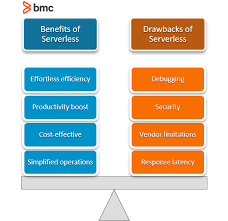
" width="300">

### Based on the lectures & images presented above:

* Reasons this approach is not efficient:
    * Time consuming - the data is being transferred from local computer to the cloud and back, each transfer of data takes time
    * Security issues - because of the data transfering between local and cloud machines mentioned above  we are exposed to data\knowledge leakage (cyber attacks) 
    * Debug abilities - in a local computer we can fully debug our code, however we cannot access all information from cloud actions, and cannot fully debug it there.
    
* Reasons this approach is efficient because:
    * Cost efficient - cloud usage is costly, and so if there are any actions we can do localy, we can save more money. 
    * Debug abilities - in a local computer we can fully debug our code.
    * Computation Resources - Relative to the map and reduce actions, the shuffle action might be lighter (in terms of required computation power) and so we can save also our serverless computing power for more complex actions.

<br><br>
**2. Suggest how can you improve shuffle so intermediate data will not be downloaded to the client at all and shuffle performed in the cloud as well. Explain pros and cons of the approaches you suggest.**


* We can improve shuffle so it will be performed in the cloud and intermediate data will not be downloaded to the client by:
    * running map --> shuffle --> reduce on the cloud each as a serverless action (or multiple ones) while persisting temp results in cloud storage
    * running map --> shuffle --> reduce on the cloud each as a serverless action (or multiple ones) while map results are passed straight to the shuffle action, and it will then be passed on straight to the reduce actions

* pro for shuffling on cloud 
    * Computation Resources: this approach frees up client computation resources.
    * Ease usage: with this approach there is no need to parse cloud results, only get final results.
* cons for shuffling on cloud 
    * Debug Abilities: it might be difficult to debug the shuffle steps in the cloud
    * Computation Utilization: cloud machines are usually strong devices that can be scaled easily. since the shuffling operation might be a relatively simple task, it would be a waste to use our strong resources for it.
    * Cloud traffic: since we are not the only users on the cloud machines, the machines might be accepting multiple requests, which might mean our job will take longer to run.
    

<br><br>
**3. Can you make serverless shuffle?**


* serverless actions can perform any task, and specifically as mentioned above we believe that we can do shuffle steps with these serverlessserverless.
* please see our answers above for pros and cons for this approach.

<br><br><br><br>
Good Luck :) 